IMPORTING MODULES

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.dim_reduction import FPCA
from skfda import FDataGrid
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.preprocessing import SplineTransformer
from patsy import dmatrix
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold

1: Loading data and creating transformation matrices

In [2]:
path = "/Users/polinaziboreva/Desktop/SPECIALE/"

save_figure_path = os.path.join(path, "figures") 
save_data_path = os.path.join(path, "data") 

csv_file = os.path.join(path, "data.csv")
data_analysis = pd.read_csv(csv_file)

Cleaning the data, calculating transformations.

In [ ]:
data_analysis = data_analysis
act_mat_full = data_analysis.loc[:, "MIN1":"MIN1440"].to_numpy(dtype=float)

# log(1 + x) transformation
act_log_mat_full = np.log1p(act_mat_full)
# square root transformation  
act_sqrt_mat_full = np.sqrt(act_mat_full) 

grouped = data_analysis.groupby("SEQN").indices

act_mat = np.vstack([np.nanmean(act_mat_full[idx, :], axis=0) for idx in grouped.values()])
act_log_mat = np.vstack([np.nanmean(act_log_mat_full[idx, :], axis=0) for idx in grouped.values()])
act_sqrt_mat = np.vstack([np.nanmean(act_sqrt_mat_full[idx, :], axis=0) for idx in grouped.values()])

data_analysis = data_analysis.loc[~data_analysis.duplicated("SEQN"), :].drop(columns=[col for col in data_analysis.columns if col.startswith("MIN")])
data_analysis = data_analysis.drop(columns=["WEEKDAY", "good_day"] + [col for col in data_analysis.columns if col.startswith("Exclude")])

#Looking only within 10 years 
censor_mort = data_analysis['time_mort'] > 10
data_analysis.loc[censor_mort, 'event'] = 0
data_analysis.loc[censor_mort, 'time_mort'] = 10

2: Smoothing and Quantile Transformation

FPCA with B-spline smoothing and qunatile transformation.

In [4]:
def smooth_fpca(matrix, n_basis = 35, n_components = 25):
    #Defining grid
    _, n_timepoints = matrix.shape
    grid_points = np.linspace(1, n_timepoints, n_timepoints)

    #Making bspline 
    fd = FDataGrid(data_matrix=matrix, grid_points=grid_points)
    bspline_basis = BSplineBasis(domain_range=(1, n_timepoints), n_basis=n_basis)
    fd_basis = fd.to_basis(bspline_basis)

    # Fitting FPCA with centering
    fpca = FPCA(n_components=n_components, centering=True)
    fpca_scores = fpca.fit_transform(fd_basis)

    #Reconstructing smoothed curves
    fpca_reconstruction = fpca.inverse_transform(fpca_scores).to_grid(grid_points=grid_points)

    return np.squeeze(fpca_reconstruction.data_matrix), fpca

def smooth_and_quantile_transform(matrix):
    result = np.zeros_like(matrix)
    for i in range(matrix.shape[1]):
        ecdf = ECDF(matrix[:, i])
        result[:, i] = ecdf(matrix[:, i])

    return result

In [5]:
act_log_mat_sm, fpcaTransformation = smooth_fpca(act_log_mat, n_basis=35, n_components=24)
act_log_mat_sm_q = smooth_and_quantile_transform(act_log_mat_sm)

The scalar covariate of smoothed LAC

In [6]:
act_log_mat_ave = np.sum(act_log_mat_sm, axis=1) / act_log_mat_sm.shape[1]

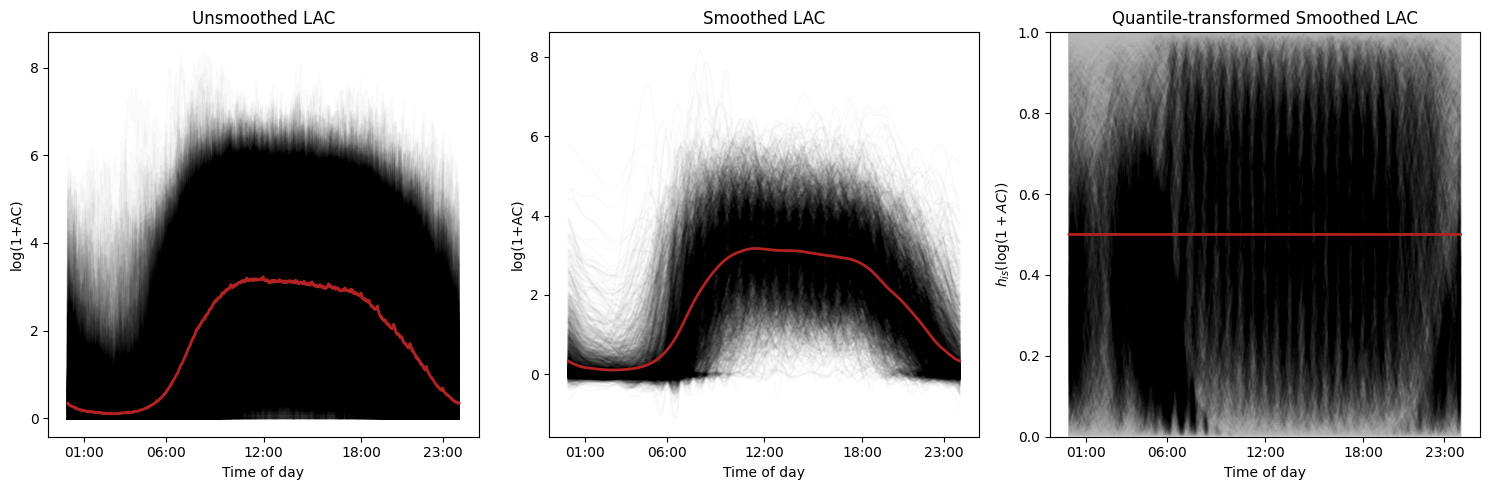

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

time_axis_1440 = np.linspace(0, 1, act_log_mat.shape[1]) 

labels = ["01:00", "06:00", "12:00", "18:00", "23:00"]
ticks = (np.array([1, 6, 12, 18, 23]) * 60 + 1) / 1440

# 1.Unsmoothed LAC
axes[0].plot(time_axis_1440, act_log_mat.T, color='black', alpha=0.02)
axes[0].plot(time_axis_1440, act_log_mat.mean(axis=0), color='firebrick', linewidth=2)
axes[0].set_title("Unsmoothed LAC")
axes[0].set_xlabel("Time of day")
axes[0].set_ylabel("log(1+AC)")
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(labels)

# 2.Smoothed LAC
axes[1].plot(time_axis_1440, act_log_mat_sm.T, color='black', alpha=0.02)
axes[1].plot(time_axis_1440, act_log_mat_sm.mean(axis=0), color='firebrick', linewidth=2)
axes[1].set_title("Smoothed LAC")
axes[1].set_xlabel("Time of day")
axes[1].set_ylabel("log(1+AC)")
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(labels)

# 3.Quantile-transformed Smoothed LAC
axes[2].plot(time_axis_1440, act_log_mat_sm_q.T, color='black', alpha=0.02)
axes[2].plot(time_axis_1440, act_log_mat_sm_q.mean(axis=0), color='firebrick', linewidth=2)
axes[2].set_title("Quantile-transformed Smoothed LAC")
axes[2].set_xlabel("Time of day")
axes[2].set_ylabel(r'$h_{is}(\log(1 + AC))$')
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(labels)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

Figure 4

Counting events and non-events

In [8]:
#calculating the number of events and nonevents on the grid under each transformation
#function "cal_evnt" returns the number of events and nonevents on the grid for given functional data
#matrix: the functional data
#time_subdiv: number of blocks on s direction, default 24
#intensity_subdiv: number of blocks on x direction, default 20
#range_x: manually set upper bound of x
#lower_x: manually set lower bound of x

def cal_evnt(transformation, matrix, events, time_subdiv=24, intensity_subdiv=20, range_x=None, lower_x=0):
    _, range_s = matrix.shape

    if range_x is None:
        range_x = np.ceil(2*np.max(matrix))/2

    event_counts_grid = np.zeros((time_subdiv, intensity_subdiv))
    nonevent_counts_grid = np.zeros((time_subdiv, intensity_subdiv))

    for s in range(time_subdiv):
        start_col = int(np.floor(s * range_s / time_subdiv))
        end_col = int(np.floor((s + 1) * range_s / time_subdiv))
        time_window = matrix[:, start_col:end_col]

        for x in range(intensity_subdiv):
            lower_bound_x = lower_x + x * (range_x - lower_x) / intensity_subdiv
            upper_bound_x = lower_x + (x + 1) * (range_x - lower_x) / intensity_subdiv

            #Rows where SEQN have any value in this time window and within intensity range
            mask = np.any((time_window >= lower_bound_x) & (time_window < upper_bound_x), axis=1)

            # Count events and non-events
            relevant_events = events[mask]
            event_counts_grid[s, x] = np.sum(relevant_events == 1)
            nonevent_counts_grid[s, x] = np.sum(relevant_events == 0)

    event_cols = [f"{transformation}.num.event.sub.{x}" for x in range(intensity_subdiv)]
    nonevent_cols = [f"{transformation}.num.nonevent.sub.{x}" for x in range(intensity_subdiv)]

    df = pd.DataFrame(
        data=np.hstack([event_counts_grid, nonevent_counts_grid]),
        columns=event_cols + nonevent_cols
    )

    df["range_s"] = range_s
    df["range_x"] = range_x
    df["lower_x"] = lower_x

    return df

In [9]:
events = data_analysis["event"].values.astype(int)

cal_evnt_log = cal_evnt("unsmoothed", act_log_mat, events)
cal_evnt_log_sm = cal_evnt("smoothed", act_log_mat_sm, events)
cal_evnt_log_sm_q = cal_evnt("smoothed_quantile", act_log_mat_sm_q, events)  

In [10]:
def extract_matrix(df, prefix, kind='event', n_block_x=20):
    col_prefix = f"{prefix}.num.{kind}.sub"
    cols = [f"{col_prefix}.{j}" for j in range(n_block_x)]
    return df[cols].to_numpy()

def plot_lac_grid_set(cal_evnt_log, cal_evnt_log_sm, cal_evnt_log_sm_q):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    x_edges = np.linspace(0, 1, 25)  
    x_labels = ["00:00", "06:00", "12:00", "18:00", "24:00"]

    datasets = [
        ("unsmoothed", cal_evnt_log, "Unsmoothed LAC"),
        ("smoothed", cal_evnt_log_sm, "Smoothed LAC"),
        ("smoothed_quantile", cal_evnt_log_sm_q, "Quantile-transformed Smoothed LAC"),
    ]

    for i, (prefix, df, title) in enumerate(datasets):
        range_x = df["range_x"].iloc[0]
        y_edges = np.linspace(0, range_x, 21)  
        y_labels = np.linspace(0, range_x, 5) if "quantile" not in prefix else np.linspace(0, 1, 5)

        # for events
        ax = axs[0, i]
        mat = extract_matrix(df, prefix, kind='event')
        mesh = ax.pcolormesh(x_edges, y_edges, mat.T, cmap='turbo', shading='auto')
        fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"{title}\n(deceased individual)")
        ax.set_xlabel("Time of day")
        ax.set_ylabel("log(1 + AC)" if "quantile" not in prefix else "hₛ(log(1 + AC))")
        ax.set_xticks(np.linspace(0, 1, 5))
        ax.set_xticklabels(x_labels)
        ax.set_yticks(np.linspace(0, range_x if "quantile" not in prefix else 1, 5))
        ax.set_yticklabels([f"{v:.2f}" for v in y_labels])

        # for non events
        ax = axs[1, i]
        mat = extract_matrix(df, prefix, kind='nonevent')
        mesh = ax.pcolormesh(x_edges, y_edges, mat.T, cmap='turbo', shading='auto')
        fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"{title}\n(alive individual)")
        ax.set_xlabel("Time of day")
        ax.set_ylabel("log(1 + AC)" if "quantile" not in prefix else "hₛ(log(1 + AC))")
        ax.set_xticks(np.linspace(0, 1, 5))
        ax.set_xticklabels(x_labels)
        ax.set_yticks(np.linspace(0, range_x if "quantile" not in prefix else 1, 5))
        ax.set_yticklabels([f"{v:.2f}" for v in y_labels])

    plt.tight_layout()
    plt.show()


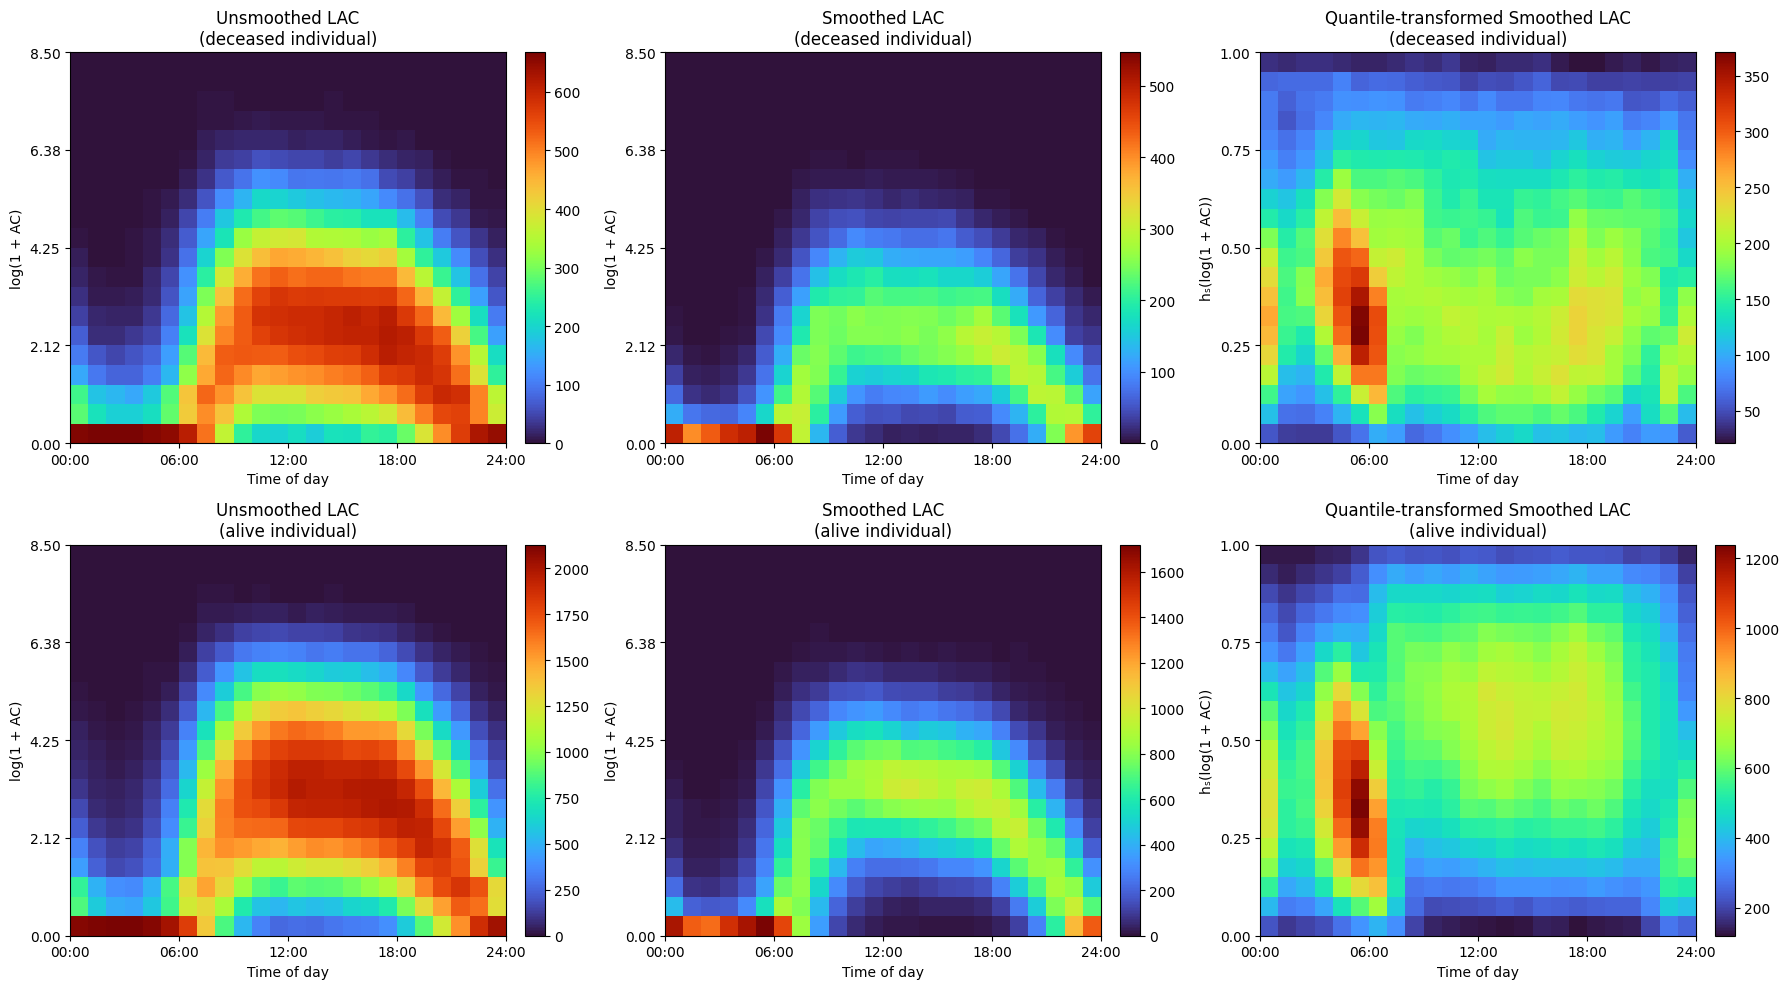

In [11]:
plot_lac_grid_set(cal_evnt_log, cal_evnt_log_sm, cal_evnt_log_sm_q)

In [12]:
def tensor_interaction(t_int, func_cov, df_time, df_cov, lmat = None):
    s = t_int.reshape(-1, 1)
    x = func_cov.reshape(-1, 1)
    t_spline = dmatrix(f"cc(s, df={df_time}) - 1", {"s": s}, return_type='dataframe').values
    x_spline = dmatrix(f"cr(x, df={df_cov}) - 1", {"x": x}, return_type='dataframe').values 

    if lmat is None or (isinstance(lmat, np.ndarray) and np.all(lmat == lmat[0, 0])):
        tensor_basis = np.einsum('ij,ik->ijk', x_spline, t_spline).reshape(len(x), -1)
    else:
        tensor_basis = np.einsum('ij,ij->ij', lmat, x_spline @ t_spline.T).reshape(len(x), -1)
    return tensor_basis

def dataframe_and_ti(ti, data, times_copy = 1440):
    fixed_covariates = [
    'Alcohol', 'Overall_health', 'PIR', 'Employed', 'Age', 'BMI_cat', 'SmokeCigs',
    'Race', 'Education', 'CHD', 'Diabetes', 'CHF', 'Stroke', 'MobilityProblem', 'Cancer'
    ]
    df_raw = data[['time_mort', 'event'] + fixed_covariates].copy()
    df_raw = df_raw.rename(columns={'time_mort': 'time'})
    df_model = pd.get_dummies(df_raw, drop_first=True)
    repeated_df_before = df_model.loc[df_model.index.repeat(times_copy)].reset_index(drop=True)
    ti_columns = [f"ti{i+1}" for i in range(len(ti[0]))]
    ti_df = pd.DataFrame(ti, columns=ti_columns)
    repeated_df = pd.concat([repeated_df_before, ti_df], axis=1)
    return repeated_df_before, repeated_df

In [13]:
def gam_fit(data, tmat, func_cov, df_time, df_cov, lmat=None, penalty=0.0001, times_copy = 1440):
    tensor_int = tensor_interaction(tmat, func_cov, df_time, df_cov, lmat)
    _, dataframe = dataframe_and_ti(tensor_int, data, times_copy)
    cph= CoxPHFitter(penalizer=penalty)
    cph.fit(dataframe, duration_col='time', event_col='event')
    cph.print_summary()

    return cph

In [14]:
def cal_tind(tlen=1):
    nt = int(np.floor(1440 / tlen))  
    tind = np.linspace(0, 1, num=nt)  
    return nt, tind

n_subjects = data_analysis.shape[0]
nt, tind = cal_tind(1)
lmat = np.full((n_subjects, nt), 1 / nt)       
tmat = np.tile(tind, (n_subjects, 1)) 

In [15]:
fit_afc_log_sm = gam_fit(data_analysis, tmat, act_log_mat_sm, 3, 3)

<lifelines.CoxPHFitter: fitted with 4.0752e+06 total observations, 3.10752e+06 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4.0752e+06
number of events observed = 967680
   partial log-likelihood = -14013525.43
         time fit was run = 2025-06-01 18:52:00 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Age                              0.09      1.09      0.00            0.09            0.09                1.09                1.09
Alcohol_Missing alcohol         -0.53      0.59      0.02           -0.56           -0.50                0.57                0.61
Alcohol_Moderate Drinker        -0.81      0.44      0.00           -0.82           -0.80                0.44                0.45
Alcohol_Non-Drinker             -0.44      0.64      0.00           -0.45           -0.43                0.64                0.65
Overall_health_Fair              0.40      1.50      0.01            0.39            0.41                1.48                1.51
Overall_health_Good              0.33      1.40      0.00            0.32            0.34                1.38                1.41
Overall_health_Poor              0.77      2.16      0.01            0.76            0.78                2.13                2.18
Overall_health_Very good         0.14      1.15      0.01            0.13            0.15                1.14                1.16
PIR_[1.0, 2.5)                  -0.05      0.95      0.00           -0.05           -0.04                0.95                0.96
PIR_[2.5, inf)                  -0.05      0.95      0.00           -0.06           -0.05                0.94                0.95
Employed_Employed: part time    -0.04      0.96      0.01           -0.05           -0.03                0.95                0.97
Employed_Unemployed: healthy     0.13      1.14      0.00            0.12            0.14                1.13                1.15
Employed_Unemployed: unhealthy   0.58      1.79      0.00            0.57            0.59                1.77                1.81
BMI_cat_Obese                   -0.20      0.82      0.00           -0.21           -0.19                0.81                0.82
BMI_cat_Overweight              -0.21      0.81      0.00           -0.21           -0.20                0.81                0.82
BMI_cat_Underweight              0.87      2.38      0.01            0.85            0.88                2.35                2.42
SmokeCigs_Former                -0.45      0.64      0.00           -0.46           -0.45                0.63                0.64
SmokeCigs_Never                 -0.90      0.41      0.00           -0.91           -0.89                0.40                0.41
Race_Mexican American           -0.19      0.83      0.00           -0.20           -0.18                0.82                0.83
Race_Other                      -0.36      0.70      0.01           -0.37           -0.34                0.69                0.71
Race_Other Hispanic             -0.36      0.70      0.01           -0.38           -0.34                0.68                0.71
Race_White                       0.01      1.01      0.00            0.00            0.02                1.00                1.02
Education_High school           -1.17      0.31      0.03           -1.22           -1.12                0.29                0.33
Education_Less than high school -1.09      0.33      0.03           -1.15           -1.04                0.32                0.35
Education_More than high school -1.13      0.32      0.03           -1.19           -1.08                0.31                0.34
Education_Refused                0.0

In [16]:
fit_afc_log_sm_q = gam_fit(data_analysis, tmat, act_log_mat_sm_q, 3, 3)

<lifelines.CoxPHFitter: fitted with 4.0752e+06 total observations, 3.10752e+06 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4.0752e+06
number of events observed = 967680
   partial log-likelihood = -14013668.64
         time fit was run = 2025-06-01 18:54:26 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Age                              0.09      1.09      0.00            0.09            0.09                1.09                1.09
Alcohol_Missing alcohol         -0.54      0.58      0.02           -0.57           -0.51                0.57                0.60
Alcohol_Moderate Drinker        -0.81      0.44      0.00           -0.82           -0.80                0.44                0.45
Alcohol_Non-Drinker             -0.44      0.64      0.00           -0.45           -0.43                0.64                0.65
Overall_health_Fair              0.40      1.50      0.01            0.39            0.41                1.48                1.51
Overall_health_Good              0.34      1.40      0.00            0.33            0.34                1.38                1.41
Overall_health_Poor              0.77      2.17      0.01            0.76            0.78                2.14                2.19
Overall_health_Very good         0.14      1.15      0.01            0.13            0.15                1.14                1.16
PIR_[1.0, 2.5)                  -0.05      0.95      0.00           -0.05           -0.04                0.95                0.96
PIR_[2.5, inf)                  -0.05      0.95      0.00           -0.06           -0.04                0.94                0.96
Employed_Employed: part time    -0.03      0.97      0.01           -0.04           -0.02                0.96                0.98
Employed_Unemployed: healthy     0.13      1.14      0.00            0.13            0.14                1.14                1.15
Employed_Unemployed: unhealthy   0.58      1.79      0.00            0.57            0.59                1.78                1.81
BMI_cat_Obese                   -0.20      0.82      0.00           -0.21           -0.19                0.81                0.82
BMI_cat_Overweight              -0.21      0.81      0.00           -0.21           -0.20                0.81                0.82
BMI_cat_Underweight              0.85      2.35      0.01            0.84            0.87                2.32                2.38
SmokeCigs_Former                -0.45      0.64      0.00           -0.46           -0.45                0.63                0.64
SmokeCigs_Never                 -0.90      0.41      0.00           -0.91           -0.89                0.40                0.41
Race_Mexican American           -0.19      0.83      0.00           -0.20           -0.18                0.82                0.83
Race_Other                      -0.35      0.70      0.01           -0.37           -0.33                0.69                0.72
Race_Other Hispanic             -0.36      0.70      0.01           -0.37           -0.34                0.69                0.71
Race_White                       0.01      1.01      0.00            0.01            0.02                1.01                1.02
Education_High school           -1.14      0.32      0.03           -1.19           -1.08                0.30                0.34
Education_Less than high school -1.06      0.35      0.03           -1.11           -1.01                0.33                0.36
Education_More than high school -1.10      0.33      0.03           -1.15           -1.05                0.32                0.35
Education_Refused                0.0

In [17]:
def cal_grid(grid_length=100, range_x=1.0, range_s=1.0):
    tind_pred = np.linspace(0, range_s, grid_length)
    xind_pred = np.linspace(0, range_x, grid_length)
    
    grid_coef = pd.DataFrame({
        't_int': np.tile(tind_pred, grid_length),           
        'func_cov': np.repeat(xind_pred, grid_length),
        'l_int': 1                                          
    })

    return grid_coef

In [18]:
def fixed_effect_df(tensorMat, ti_col = 3, num_repeat = 10000):
    fix_effects_pred = data_analysis[['Alcohol', 'Overall_health', 'PIR', 'Employed',
                                'Age', 'BMI_cat', 'SmokeCigs', 'Race', 'Education',
                                'CHD', 'Diabetes', 'CHF', 'Stroke', 'MobilityProblem', 'Cancer']]
    fixed_effects_pred = pd.get_dummies(fix_effects_pred, drop_first=True)
    fixed_effects_dummies_justOne = fixed_effects_pred[0:1]
    fixed_effects_dummies_repeated = pd.concat([fixed_effects_dummies_justOne] * num_repeat, ignore_index=True)

    ti_columns = [f"ti{i+1}" for i in range(ti_col)]
    ti_df_pred = pd.DataFrame(tensorMat, columns=ti_columns)    
    fixed_effects_dummies_repeated = pd.concat([fixed_effects_dummies_repeated, ti_df_pred], axis=1)
    return fixed_effects_dummies_repeated

In [19]:
def vis_surf(coef_matrix, trans_name, grid_length=100, simulation=False, transformation=True,
             range_x=1.0, range_s=1.0):

    coef_df = pd.DataFrame(coef_matrix)
    coef_df = coef_df.reset_index().melt(id_vars='index')
    coef_df.columns = ['Var1', 'Var2', 'value']
    pivot_table = coef_df.pivot(index="Var2", columns="Var1", values="value")

    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(pivot_table, cmap='seismic', cbar_kws={'label': r'$\hat{F}(\cdot,\cdot)$'}, 
                     xticklabels=False, yticklabels=False)
    ax.invert_yaxis()  
    ax.set_title(trans_name, fontsize=15, fontweight='bold')

    if simulation:
        ax.set_xlabel("Functional domain")
        ax.set_ylabel("Value of functional covariate")

        ticks = np.linspace(0, grid_length - 1, 6).astype(int)
        ax.set_xticks(ticks)
        ax.set_xticklabels(np.round(np.linspace(0, range_s, 6), 2))
        ax.set_yticks(ticks)
        ax.set_yticklabels(np.round(np.linspace(0, range_x, 6), 2))

    else:
        ax.set_xlabel("Time of day")
        ax.set_ylabel(r'$h_{is}(\log(1 + AC))$' if transformation else r'$\log(1 + AC)$')

        xticks = [0, int(0.25 * grid_length), int(0.5 * grid_length), int(0.75 * grid_length), grid_length - 1]
        ax.set_xticks(xticks)
        ax.set_xticklabels(["00:00", "06:00", "12:00", "18:00", "24:00"])

        yticks = np.linspace(0, grid_length - 1, 5).astype(int)
        ax.set_yticks(yticks)
        ax.set_yticklabels(np.round(np.linspace(0, range_x, 5), 2))

    plt.tight_layout()
    plt.show()

In [20]:
def vis_stratified(data, period, grid_length=100):
    if period == "night":
        nt = 480
        ind = list(range(0, 480))  
    elif period == "day":
        nt = 960
        ind = list(range(480, 1440))  
    pctl = 0.9
    act_log_mat_period = act_log_mat[:, ind]
    func_cov_1, _ = smooth_fpca(act_log_mat_period, n_basis=40, n_components=28)
    name_y = "log(1+AC)"

    n_rows = func_cov_1.shape[0]
    t_int = np.tile(np.linspace(0, 1, nt), (n_rows, 1))
    l_int = np.full((n_rows, nt), 1 / nt)
    cph_period = gam_fit(data, t_int, func_cov_1, 5, 3, nt)

    range_x = np.quantile(func_cov_1, pctl)

    grid = cal_grid(grid_length, range_x)
    x_pred = tensor_interaction(grid['t_int'].values, grid['func_cov'].values, 5, 3)
    f_e_df = fixed_effect_df(x_pred, ti_col=5)

    cmh_pred = cph_period.predict_log_partial_hazard(f_e_df)
    score_matrix =  np.array(cmh_pred).reshape((grid_length, grid_length), order='F') 
    
    return score_matrix, range_x
    

In [ ]:
def plot_daynight_surface(score_matrix, period, trans_name=None, grid_length=100, transformation=True, range_x=1.0):
    coef_df = pd.DataFrame(score_matrix)
    coef_df = coef_df.reset_index().melt(id_vars='index')
    coef_df.columns = ['Var1', 'Var2', 'value']
    pivot_table = coef_df.pivot(index="Var2", columns="Var1", values="value")

    if period == "night":
        title = "Night"
        xticks = [0, int(0.5 * grid_length), grid_length - 1]
        xtick_labels = ["00:00", "04:00", "08:00"]
    elif period == "day":
        title = "Daytime"
        xticks = [0, int(0.25 * grid_length), int(0.5 * grid_length), int(0.75 * grid_length), grid_length - 1]
        xtick_labels = ["08:00", "12:00", "16:00", "20:00", "24:00"]
    else:
        raise ValueError("Period must be 'night' or 'day'")

    title = trans_name if trans_name else title

    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(pivot_table, cmap='seismic', cbar_kws={'label': r'$\hat{F}(\cdot,\cdot)$'},
                     xticklabels=False, yticklabels=False)
    ax.invert_yaxis()
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_xlabel("Time of day")
    ax.set_ylabel(r'$h_{is}(\log(1 + AC))$' if transformation else r'$\log(1 + AC)$')

    # Set custom ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)

    yticks = np.linspace(0, grid_length - 1, 5).astype(int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.round(np.linspace(0, range_x, 5), 2))

    plt.tight_layout()
    plt.show()


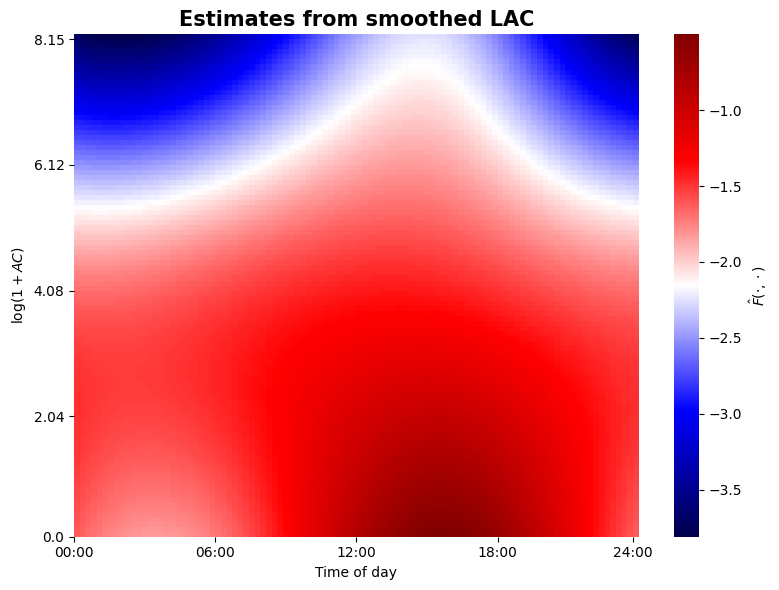

In [22]:
grid_length = 100
range_x = np.max(act_log_mat_sm)
range_s = 1.0   # standard time range
grid = cal_grid(grid_length=grid_length, range_x=range_x, range_s=range_s)
x_pred_sm = tensor_interaction(grid['t_int'].values, grid['func_cov'].values, 3, 3)
fixed_effects_df_sm = fixed_effect_df(x_pred_sm, ti_col=9)
cmh_pred_sm = fit_afc_log_sm.predict_log_partial_hazard(fixed_effects_df_sm)
score_matrix_sm =  np.array(cmh_pred_sm).reshape((grid_length, grid_length), order='F') 
vis_surf(score_matrix_sm, trans_name="Estimates from smoothed LAC", range_x=range_x, range_s=range_s, transformation=False)


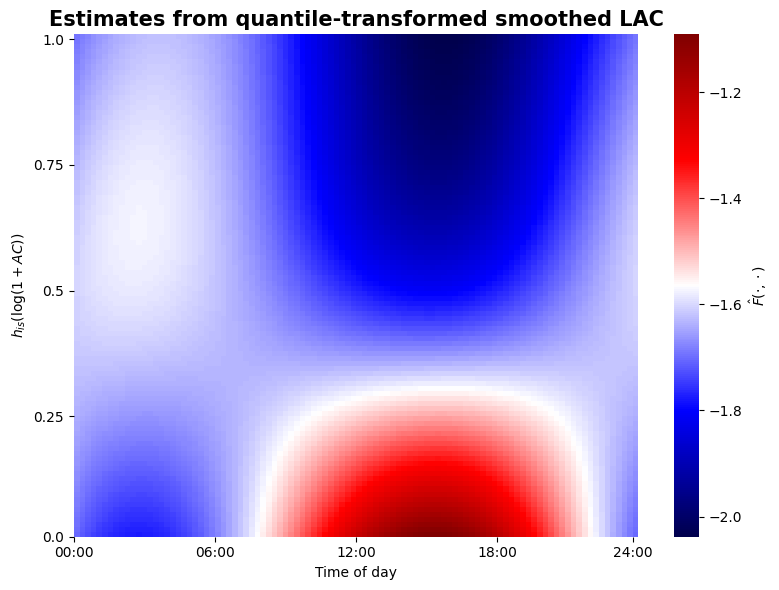

In [23]:
grid_length = 100
range_x = 1.0   
range_s = 1.0  
grid = cal_grid(grid_length=grid_length, range_x=range_x, range_s=range_s)
x_pred_sm_q = tensor_interaction(grid['t_int'].values, grid['func_cov'].values, 3, 3)
fixed_effects_df_sm_q = fixed_effect_df(x_pred_sm_q, ti_col=9)
cmh_pred_sm_q = fit_afc_log_sm_q.predict_log_partial_hazard(fixed_effects_df_sm_q)
score_matrix_sm_q =  np.array(cmh_pred_sm_q).reshape((grid_length, grid_length), order='F') 
vis_surf(score_matrix_sm_q, trans_name="Estimates from quantile-transformed smoothed LAC", range_x=range_x, range_s=range_s, transformation=True)

In [35]:
def tensor_interaction_period(t_int, func_cov, df_time, df_cov, lmat = None):
    s = t_int.reshape(-1, 1)
    x = func_cov.reshape(-1, 1)
    t_spline = dmatrix(f"cc(s, df={df_time}) - 1", {"s": s}, return_type='dataframe').values
    x_spline = dmatrix(f"cr(x, df={df_cov}) - 1", {"x": x}, return_type='dataframe').values 

    if lmat is None or (isinstance(lmat, np.ndarray) and np.all(lmat == lmat[0, 0])):
        tensor_basis = np.einsum('ij,ik->ijk', x_spline, t_spline).reshape(len(x), -1)
    else:
        tensor_basis = np.einsum('ij,ij->ij', lmat, x_spline @ t_spline.T).reshape(len(x), -1)
    return tensor_basis


def gam_fit_period(data, tmat, func_cov, df_time, df_cov, lmat=None, penalty=0.0001, times_copy = 1440):
    tensor_int = tensor_interaction_period(tmat, func_cov, df_time, df_cov, lmat)
    _, dataframe = dataframe_and_ti(tensor_int, data, times_copy)
    cph= CoxPHFitter(penalizer=penalty)
    cph.fit(dataframe, duration_col='time', event_col='event')
    cph.print_summary()

    return cph

def vis_stratified(data, period, grid_length=100):
    if period == "night":
        nt = 480
        ind = list(range(0, 480))  
    elif period == "day":
        nt = 960
        ind = list(range(480, 1440))  
    pctl = 0.9
    act_log_mat_period = act_log_mat[:, ind]
    func_cov_1, _ = smooth_fpca(act_log_mat_period, n_basis=35, n_components=24)
    name_y = "log(1+AC)"

    n_rows = func_cov_1.shape[0]
    t_int = np.tile(np.linspace(0, 1, nt), (n_rows, 1))
    l_int = np.full((n_rows, nt), 1 / nt)
    cph_period = gam_fit_period(data, t_int, func_cov_1, 3, 3, lmat=l_int, times_copy=nt)

    range_x = np.quantile(func_cov_1, pctl)

    grid = cal_grid(grid_length, range_x)
    x_pred = tensor_interaction_period(grid['t_int'].values, grid['func_cov'].values, 3, 3, lmat=l_int)
    f_e_df = fixed_effect_df(x_pred, ti_col=9)

    cmh_pred = cph_period.predict_log_partial_hazard(f_e_df)
    score_matrix =  np.array(cmh_pred).reshape((grid_length, grid_length), order='F') 
    
    return score_matrix, range_x
    

In [ ]:
def plot_daynight_surface(score_matrix, period, trans_name=None, grid_length=100, transformation=True, range_x=1.0):
    coef_df = pd.DataFrame(score_matrix)
    coef_df = coef_df.reset_index().melt(id_vars='index')
    coef_df.columns = ['Var1', 'Var2', 'value']
    pivot_table = coef_df.pivot(index="Var2", columns="Var1", values="value")

    if period == "night":
        title = "Night"
        xticks = [0, int(0.5 * grid_length), grid_length - 1]
        xtick_labels = ["00:00", "04:00", "08:00"]
    elif period == "day":
        title = "Daytime"
        xticks = [0, int(0.25 * grid_length), int(0.5 * grid_length), int(0.75 * grid_length), grid_length - 1]
        xtick_labels = ["08:00", "12:00", "16:00", "20:00", "24:00"]
    else:
        raise ValueError("Period must be 'night' or 'day'")

    title = trans_name if trans_name else title

    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(pivot_table, cmap='seismic', cbar_kws={'label': r'$\hat{F}(\cdot,\cdot)$'},
                     xticklabels=False, yticklabels=False)
    ax.invert_yaxis()
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_xlabel("Time of day")
    ax.set_ylabel(r'$h_{is}(\log(1 + AC))$' if transformation else r'$\log(1 + AC)$')

    # Set custom ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)

    yticks = np.linspace(0, grid_length - 1, 5).astype(int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.round(np.linspace(0, range_x, 5), 2))

    plt.tight_layout()
    plt.show()


In [ ]:
def tensor_interaction_period(t_int, func_cov, df_time, df_cov, lmat = None):
    s = t_int.reshape(-1, 1)
    x = func_cov.reshape(-1, 1)
    t_spline = dmatrix(f"cr(s, df={df_time}) - 1", {"s": s}, return_type='dataframe').values
    x_spline = dmatrix(f"cr(x, df={df_cov}) - 1", {"x": x}, return_type='dataframe').values 
    if lmat is None or (isinstance(lmat, np.ndarray) and np.all(lmat == lmat[0, 0])):
        tensor_basis = np.einsum('ij,ik->ijk', x_spline, t_spline).reshape(len(x), -1)
    else:
        tensor_basis = np.einsum('ij,ij->ij', lmat, x_spline @ t_spline.T).reshape(len(x), -1)
    return tensor_basis

In [26]:
score_mat_night, range_x_night = vis_stratified(data_analysis, "night")

<lifelines.CoxPHFitter: fitted with 1.3584e+06 total observations, 1.03584e+06 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1.3584e+06
number of events observed = 322560
   partial log-likelihood = -4320880.88
         time fit was run = 2025-06-01 18:57:22 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Age                              0.09      1.10      0.00            0.09            0.09                1.10                1.10
Alcohol_Missing alcohol         -0.54      0.58      0.03           -0.60           -0.49                0.55                0.61
Alcohol_Moderate Drinker        -0.84      0.43      0.01           -0.85           -0.82                0.43                0.44
Alcohol_Non-Drinker             -0.46      0.63      0.01           -0.47           -0.45                0.62                0.64
Overall_health_Fair              0.42      1.52      0.01            0.40            0.44                1.49                1.55
Overall_health_Good              0.34      1.40      0.01            0.32            0.36                1.38                1.43
Overall_health_Poor              0.79      2.21      0.01            0.77            0.81                2.16                2.26
Overall_health_Very good         0.13      1.14      0.01            0.11            0.15                1.12                1.16
PIR_[1.0, 2.5)                  -0.04      0.96      0.01           -0.05           -0.03                0.95                0.97
PIR_[2.5, inf)                  -0.04      0.96      0.01           -0.05           -0.03                0.95                0.97
Employed_Employed: part time    -0.02      0.98      0.01           -0.03            0.00                0.97                1.00
Employed_Unemployed: healthy     0.16      1.18      0.01            0.15            0.18                1.16                1.19
Employed_Unemployed: unhealthy   0.62      1.87      0.01            0.61            0.64                1.84                1.90
BMI_cat_Obese                   -0.17      0.84      0.00           -0.18           -0.16                0.84                0.85
BMI_cat_Overweight              -0.21      0.81      0.00           -0.22           -0.20                0.81                0.82
BMI_cat_Underweight              0.83      2.30      0.01            0.81            0.86                2.24                2.36
SmokeCigs_Former                -0.49      0.62      0.01           -0.50           -0.48                0.61                0.62
SmokeCigs_Never                 -0.93      0.39      0.01           -0.94           -0.92                0.39                0.40
Race_Mexican American           -0.20      0.82      0.01           -0.21           -0.19                0.81                0.83
Race_Other                      -0.36      0.70      0.02           -0.39           -0.33                0.68                0.72
Race_Other Hispanic             -0.34      0.71      0.02           -0.37           -0.31                0.69                0.74
Race_White                       0.01      1.01      0.01           -0.00            0.02                1.00                1.02
Education_High school           -1.05      0.35      0.05           -1.14           -0.96                0.32                0.38
Education_Less than high school -0.98      0.38      0.05           -1.07           -0.89                0.34                0.41
Education_More than high school -1.01      0.36      0.05           -1.10           -0.92                0.33                0.40
Education_Refused                0.25

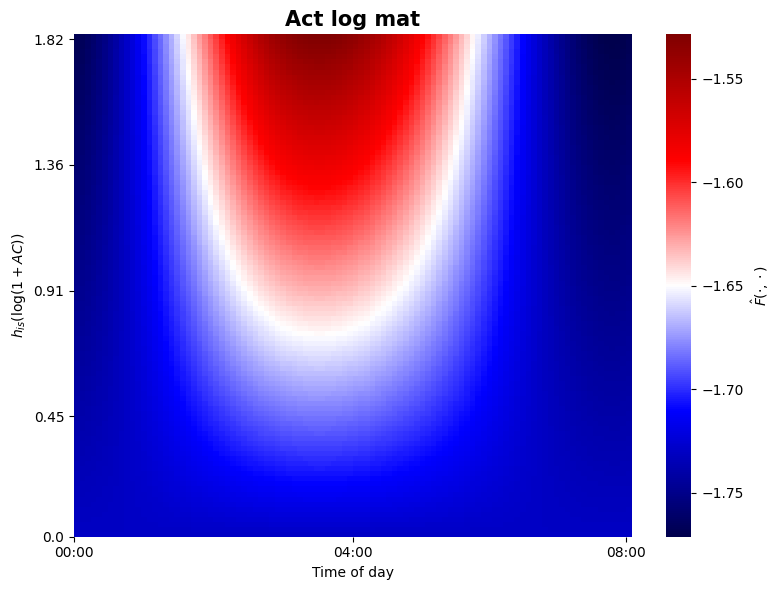

In [28]:
plot_daynight_surface(score_mat_night, period="night", trans_name = "Act log mat", range_x = range_x_night)

In [37]:
score_mat_day, range_x_day = vis_stratified(data_analysis, "day")

<lifelines.CoxPHFitter: fitted with 2.7168e+06 total observations, 2.07168e+06 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2.7168e+06
number of events observed = 645120
   partial log-likelihood = -9076352.60
         time fit was run = 2025-06-01 19:04:49 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Age                              0.09      1.09      0.00            0.09            0.09                1.09                1.09
Alcohol_Missing alcohol         -0.53      0.59      0.02           -0.57           -0.49                0.57                0.61
Alcohol_Moderate Drinker        -0.79      0.45      0.00           -0.80           -0.78                0.45                0.46
Alcohol_Non-Drinker             -0.43      0.65      0.00           -0.44           -0.42                0.65                0.66
Overall_health_Fair              0.40      1.50      0.01            0.39            0.42                1.48                1.52
Overall_health_Good              0.34      1.41      0.01            0.33            0.35                1.39                1.42
Overall_health_Poor              0.77      2.16      0.01            0.76            0.79                2.13                2.19
Overall_health_Very good         0.15      1.17      0.01            0.14            0.17                1.15                1.18
PIR_[1.0, 2.5)                  -0.05      0.95      0.00           -0.06           -0.05                0.94                0.95
PIR_[2.5, inf)                  -0.06      0.94      0.00           -0.07           -0.05                0.93                0.95
Employed_Employed: part time    -0.04      0.96      0.01           -0.05           -0.02                0.95                0.98
Employed_Unemployed: healthy     0.12      1.13      0.00            0.11            0.13                1.12                1.14
Employed_Unemployed: unhealthy   0.57      1.77      0.01            0.56            0.58                1.75                1.79
BMI_cat_Obese                   -0.21      0.81      0.00           -0.22           -0.21                0.80                0.81
BMI_cat_Overweight              -0.21      0.81      0.00           -0.21           -0.20                0.81                0.82
BMI_cat_Underweight              0.88      2.40      0.01            0.86            0.89                2.36                2.45
SmokeCigs_Former                -0.44      0.65      0.00           -0.44           -0.43                0.64                0.65
SmokeCigs_Never                 -0.88      0.41      0.00           -0.89           -0.87                0.41                0.42
Race_Mexican American           -0.18      0.83      0.00           -0.19           -0.17                0.83                0.84
Race_Other                      -0.35      0.71      0.01           -0.37           -0.32                0.69                0.72
Race_Other Hispanic             -0.36      0.70      0.01           -0.39           -0.34                0.68                0.71
Race_White                       0.02      1.02      0.00            0.01            0.02                1.01                1.02
Education_High school           -1.21      0.30      0.03           -1.28           -1.15                0.28                0.32
Education_Less than high school -1.13      0.32      0.03           -1.20           -1.07                0.30                0.34
Education_More than high school -1.18      0.31      0.03           -1.24           -1.11                0.29                0.33
Education_Refused               -0.08

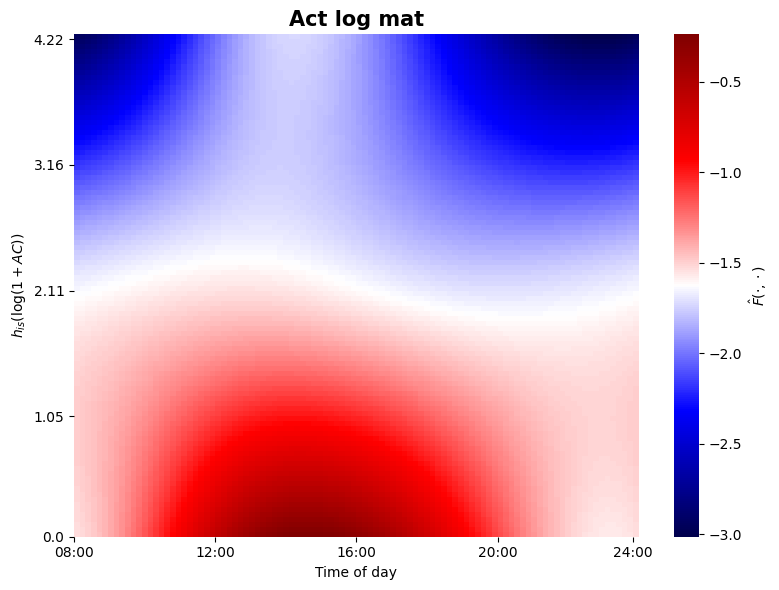

In [38]:
plot_daynight_surface(score_mat_day, period="day", trans_name = "Act log mat", range_x = range_x_day)

EVALUATION 

In [39]:
def dataframe_and_ti_train(ti, data, times_copy = 1440):
    fixed_covariates = [
    'Alcohol', 'Overall_health', 'PIR', 'Employed', 'Age', 'BMI_cat', 'SmokeCigs',
    'Race', 'Education', 'CHD', 'Diabetes', 'CHF', 'Stroke', 'MobilityProblem', 'Cancer'
    ]
    df_raw = data[['time_mort', 'event'] + fixed_covariates].copy()
    df_raw = df_raw.rename(columns={'time_mort': 'time'})
    df_model = pd.get_dummies(df_raw, drop_first=True)
    repeated_df_before = df_model.loc[df_model.index.repeat(times_copy)].reset_index(drop=True)
    ti_columns = [f"ti{i+1}" for i in range(len(ti[0]))]
    ti_df = pd.DataFrame(ti, columns=ti_columns)
    repeated_df = pd.concat([repeated_df_before, ti_df], axis=1)
    return repeated_df_before, repeated_df

In [40]:
def gam_fit_train(time, cov, tK, cK, data, lmat = None, penalty=0.0001, times_copy = 1440):
    tensor_int = tensor_interaction(time, cov, tK, cK, lmat)
    _, df = dataframe_and_ti_train(tensor_int, data, times_copy)
    cph= CoxPHFitter(penalizer=penalty)
    cph.fit(df, duration_col='time', event_col='event')
    return cph

In [41]:
def missing_col_test(df, columns):
    for col in columns:
        if col not in df.columns:
            df[col] = False
    return df

In [ ]:
np.random.seed(135)
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=135)
iAUC_afc = np.zeros(n_folds)
iAUC_afc_sm = np.zeros(n_folds)
iAUC_afc_sm_q = np.zeros(n_folds)
iAUC_lfc = np.zeros(n_folds)
iAUC_lfc_sm = np.zeros(n_folds)
iAUC_lfc_sm_q = np.zeros(n_folds)
iAUC_cph = np.zeros(n_folds)

In [43]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data_analysis['time_mort'])):
    print(f"Fold {fold_idx + 1}/{n_folds}")
    
    train_data = data_analysis.iloc[train_idx]
    test_data = data_analysis.iloc[test_idx]

    train_t_mat = tmat[train_idx]
    train_l_mat = lmat[train_idx]
    train_func_cov = act_log_mat[train_idx]

    test_t_mat = tmat[test_idx]
    test_l_mat = lmat[test_idx]
    test_func_cov = act_log_mat[test_idx]

    xx = pd.get_dummies(train_data, drop_first=True)
    yy = pd.get_dummies(test_data, drop_first=True)
    train_not_test = set(xx.columns) - set(yy.columns)

    gam_train_alm = gam_fit_train(train_t_mat, train_func_cov, 3, 3, train_data)

    tensor_test = tensor_interaction(test_t_mat, test_func_cov, df_time=3, df_cov=3, lmat=test_l_mat)
    _, df_test = dataframe_and_ti_train(tensor_test, test_data) 
    
    n_rows = tensor_test.shape[0]
    n_subjects = n_rows // 1440

    df_test = missing_col_test(df_test, train_not_test)
    risk_scores = gam_train_alm.predict_log_partial_hazard(df_test)

    risk_scores = risk_scores.to_numpy()
    risk_scores = risk_scores.reshape((n_subjects, 1440))
    risk_scores = risk_scores.mean(axis=1)

    cindex = concordance_index(
        event_times=test_data["time_mort"].values,
        predicted_scores=-risk_scores,
        event_observed=test_data["event"].values
    )

    iAUC_afc[fold_idx] = cindex

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [44]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data_analysis['time_mort'])):
    print(f"Fold {fold_idx + 1}/{n_folds}")
    
    train_data = data_analysis.iloc[train_idx]
    test_data = data_analysis.iloc[test_idx]

    train_t_mat = tmat[train_idx]
    train_l_mat = lmat[train_idx]
    train_func_cov = act_log_mat_sm[train_idx]

    test_t_mat = tmat[test_idx]
    test_l_mat = lmat[test_idx]
    test_func_cov = act_log_mat_sm[test_idx]

    xx = pd.get_dummies(train_data, drop_first=True)
    yy = pd.get_dummies(test_data, drop_first=True)
    train_not_test = set(xx.columns) - set(yy.columns)

    gam_train_alm = gam_fit_train(train_t_mat, train_func_cov, 3, 3, train_data)

    tensor_test = tensor_interaction(test_t_mat, test_func_cov, df_time=3, df_cov=3, lmat=test_l_mat)
    _, df_test = dataframe_and_ti_train(tensor_test, test_data) 
    
    n_rows = tensor_test.shape[0]
    n_subjects = n_rows // 1440

    df_test = missing_col_test(df_test, train_not_test)
    risk_scores = gam_train_alm.predict_log_partial_hazard(df_test)

    risk_scores = risk_scores.to_numpy()
    risk_scores = risk_scores.reshape((n_subjects, 1440))
    risk_scores = risk_scores.mean(axis=1)s

    cindex = concordance_index(
        event_times=test_data["time_mort"].values,
        predicted_scores=-risk_scores,
        event_observed=test_data["event"].values
    )

    iAUC_afc_sm[fold_idx] = cindex

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [45]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data_analysis['time_mort'])):
    print(f"Fold {fold_idx + 1}/{n_folds}")
    
    train_data = data_analysis.iloc[train_idx]
    test_data = data_analysis.iloc[test_idx]

    train_t_mat = tmat[train_idx]
    train_l_mat = lmat[train_idx]
    train_func_cov = act_log_mat_sm_q[train_idx]

    test_t_mat = tmat[test_idx]
    test_l_mat = lmat[test_idx]
    test_func_cov = act_log_mat_sm_q[test_idx]

    xx = pd.get_dummies(train_data, drop_first=True)
    yy = pd.get_dummies(test_data, drop_first=True)
    train_not_test = set(xx.columns) - set(yy.columns)

    gam_train_alm = gam_fit_train(train_t_mat, train_func_cov, 3, 3, train_data)

    tensor_test = tensor_interaction(test_t_mat, test_func_cov, df_time=3, df_cov=3, lmat=test_l_mat)
    _, df_test = dataframe_and_ti_train(tensor_test, test_data) 
    
    n_rows = tensor_test.shape[0]
    n_subjects = n_rows // 1440

    df_test = missing_col_test(df_test, train_not_test)
    risk_scores = gam_train_alm.predict_log_partial_hazard(df_test)

    risk_scores = risk_scores.to_numpy()
    risk_scores = risk_scores.reshape((n_subjects, 1440))
    risk_scores = risk_scores.mean(axis=1)

    cindex = concordance_index(
        event_times=test_data["time_mort"].values,
        predicted_scores=-risk_scores,
        event_observed=test_data["event"].values
    )

    iAUC_afc_sm_q[fold_idx] = cindex

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [47]:
def tensor_interaction_S(t_int, func_cov, df_time, lmat = None):
    s = t_int.reshape(-1, 1)
    x = func_cov.reshape(-1, 1)
    t_spline = dmatrix(f"cc(s, df={df_time}) - 1", {"s": s}, return_type='dataframe').values

    if lmat is None or (isinstance(lmat, np.ndarray) and np.all(lmat == lmat[0, 0])):
        tensor_basis = np.einsum('ij,ik->ijk', x, t_spline).reshape(len(x), -1)
    else:
        tensor_basis = np.einsum('ij,ij->ij', lmat, x @ t_spline.T).reshape(len(x), -1)
    return tensor_basis

In [48]:
def gam_fit_train_S(time, cov, tK, data, lmat = None, penalty=0.0001, times_copy = 1440):
    tensor_int = tensor_interaction_S(time, cov, tK, lmat)
    _, df = dataframe_and_ti_train(tensor_int, data, times_copy)
    cph= CoxPHFitter(penalizer=penalty)
    cph.fit(df, duration_col='time', event_col='event')

    return cph

In [49]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data_analysis['time_mort'])):
    print(f"Fold {fold_idx + 1}/{n_folds}")
    
    train_data = data_analysis.iloc[train_idx]
    test_data = data_analysis.iloc[test_idx]

    train_t_mat = tmat[train_idx]
    train_l_mat = lmat[train_idx]
    train_func_cov = act_log_mat[train_idx]

    test_t_mat = tmat[test_idx]
    test_l_mat = lmat[test_idx]
    test_func_cov = act_log_mat[test_idx]

    xx = pd.get_dummies(train_data, drop_first=True)
    yy = pd.get_dummies(test_data, drop_first=True)
    train_not_test = set(xx.columns) - set(yy.columns)

    gam_train_alm = gam_fit_train_S(train_t_mat, train_func_cov, 10, train_data)

    tensor_test = tensor_interaction_S(test_t_mat, test_func_cov, df_time=10, lmat=test_l_mat)
    _, df_test = dataframe_and_ti_train(tensor_test, test_data) 
    
    n_rows = tensor_test.shape[0]
    n_subjects = n_rows // 1440

    df_test = missing_col_test(df_test, train_not_test)
    risk_scores = gam_train_alm.predict_log_partial_hazard(df_test)

    risk_scores = risk_scores.to_numpy()
    risk_scores = risk_scores.reshape((n_subjects, 1440))
    risk_scores = risk_scores.mean(axis=1)

    cindex = concordance_index(
        event_times=test_data["time_mort"].values,
        predicted_scores=-risk_scores,
        event_observed=test_data["event"].values
    )

    iAUC_lfc[fold_idx] = cindex

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [50]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data_analysis['time_mort'])):
    print(f"Fold {fold_idx + 1}/{n_folds}")
    
    train_data = data_analysis.iloc[train_idx]
    test_data = data_analysis.iloc[test_idx]

    train_t_mat = tmat[train_idx]
    train_l_mat = lmat[train_idx]
    train_func_cov = act_log_mat_sm[train_idx]

    test_t_mat = tmat[test_idx]
    test_l_mat = lmat[test_idx]
    test_func_cov = act_log_mat_sm[test_idx]

    xx = pd.get_dummies(train_data, drop_first=True)
    yy = pd.get_dummies(test_data, drop_first=True)
    train_not_test = set(xx.columns) - set(yy.columns)

    gam_train_alm = gam_fit_train_S(train_t_mat, train_func_cov, 10, train_data)

    tensor_test = tensor_interaction_S(test_t_mat, test_func_cov, df_time=10, lmat=test_l_mat)
    _, df_test = dataframe_and_ti_train(tensor_test, test_data) 
    
    n_rows = tensor_test.shape[0]
    n_subjects = n_rows // 1440

    df_test = missing_col_test(df_test, train_not_test)
    risk_scores = gam_train_alm.predict_log_partial_hazard(df_test)

    risk_scores = risk_scores.to_numpy()
    risk_scores = risk_scores.reshape((n_subjects, 1440))
    risk_scores = risk_scores.mean(axis=1)

    cindex = concordance_index(
        event_times=test_data["time_mort"].values,
        predicted_scores=-risk_scores,
        event_observed=test_data["event"].values
    )

    iAUC_lfc_sm[fold_idx] = cindex

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [51]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data_analysis['time_mort'])):
    print(f"Fold {fold_idx + 1}/{n_folds}")
    
    train_data = data_analysis.iloc[train_idx]
    test_data = data_analysis.iloc[test_idx]

    train_t_mat = tmat[train_idx]
    train_l_mat = lmat[train_idx]
    train_func_cov = act_log_mat_sm_q[train_idx]

    test_t_mat = tmat[test_idx]
    test_l_mat = lmat[test_idx]
    test_func_cov = act_log_mat_sm_q[test_idx]

    xx = pd.get_dummies(train_data, drop_first=True)
    yy = pd.get_dummies(test_data, drop_first=True)
    train_not_test = set(xx.columns) - set(yy.columns)

    gam_train_alm = gam_fit_train_S(train_t_mat, train_func_cov, 10, train_data)

    tensor_test = tensor_interaction_S(test_t_mat, test_func_cov, df_time=10, lmat=test_l_mat)
    _, df_test = dataframe_and_ti_train(tensor_test, test_data) 
    
    n_rows = tensor_test.shape[0]
    n_subjects = n_rows // 1440

    df_test = missing_col_test(df_test, train_not_test)
    risk_scores = gam_train_alm.predict_log_partial_hazard(df_test)

    risk_scores = risk_scores.to_numpy()
    risk_scores = risk_scores.reshape((n_subjects, 1440))
    risk_scores = risk_scores.mean(axis=1)

    cindex = concordance_index(
        event_times=test_data["time_mort"].values,
        predicted_scores=-risk_scores,
        event_observed=test_data["event"].values
    )

    iAUC_lfc_sm_q[fold_idx] = cindex

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [52]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data_analysis['time_mort'])):
    print(f"Fold {fold_idx + 1}/{n_folds}")
    
    train_data = data_analysis.iloc[train_idx]
    test_data = data_analysis.iloc[test_idx]

    train_t_mat = tmat[train_idx]
    train_l_mat = lmat[train_idx]
    train_func_cov = act_log_mat_ave[train_idx]

    test_t_mat = tmat[test_idx]
    test_l_mat = lmat[test_idx]
    test_func_cov = act_log_mat_ave[test_idx]

    xx = pd.get_dummies(train_data, drop_first=True)
    yy = pd.get_dummies(test_data, drop_first=True)
    train_not_test = set(xx.columns) - set(yy.columns)

    fixed_covariates = [
    'Alcohol', 'Overall_health', 'PIR', 'Employed', 'Age', 'BMI_cat', 'SmokeCigs',
    'Race', 'Education', 'CHD', 'Diabetes', 'CHF', 'Stroke', 'MobilityProblem', 'Cancer'
    ]
    df_raw = train_data[['time_mort', 'event'] + fixed_covariates].copy()
    df_raw['act_log_mat_ave'] = train_func_cov 
    df_raw = df_raw.rename(columns={'time_mort': 'time'})
    df_model = pd.get_dummies(df_raw, drop_first=True)

    fit_cph_cv = CoxPHFitter(penalizer=0.0001)
    fit_cph_cv.fit(df_model, duration_col='time', event_col='event')

    df_raw_test = test_data[['time_mort', 'event'] + fixed_covariates].copy()
    df_raw_test['act_log_mat_ave'] = test_func_cov 
    df_model_test = pd.get_dummies(df_raw_test, drop_first=True)
    df_model_test = missing_col_test(df_model_test, train_not_test)

    eta_cph_cv = fit_cph_cv.predict_log_partial_hazard(df_model_test)
    eta_cph_cv = eta_cph_cv.to_numpy()

    cindex = concordance_index(
        event_times=test_data["time_mort"].values,
        predicted_scores=-eta_cph_cv,
        event_observed=test_data["event"].values
    )

    iAUC_cph[fold_idx] = cindex

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [74]:
print("All scores unsmoothed AFCM:", iAUC_afc)
print("Mean scores unsmoothed AFCM:", np.mean(np.round(iAUC_afc,2)))

All scores unsmoothed AFCM: [0.65642212 0.68866527 0.70097626 0.60586411 0.62357351 0.58142164
 0.57360502 0.53712871 0.67754654 0.69176082]
Mean scores unsmoothed AFCM: 0.634


In [75]:
print("All scores smoothed AFCM:", iAUC_afc_sm)
print("Mean scores smoothed AFCM:", np.mean(np.round(iAUC_afc_sm,2)))

All scores smoothed AFCM: [0.6590108  0.69360415 0.70398939 0.61051593 0.62776908 0.58541126
 0.57893417 0.54101035 0.67896846 0.69506751]
Mean scores smoothed AFCM: 0.638


In [66]:
print("All scores smoothed + quantile AFCM:", iAUC_afc_sm_q)
print("Mean scores smoothed + quantile AFCM:", np.mean(np.round(iAUC_afc_sm_q,3)))

All scores smoothed + quantile AFCM: [0.65752368 0.69187554 0.70362782 0.60882436 0.62569926 0.5839484
 0.57774295 0.54022277 0.67883919 0.69391017]
Mean scores smoothed + quantile AFCM: 0.6364


In [71]:
print("All scores unsmoothed LFCM:", iAUC_lfc)
print("Mean scores unsmoothed LFCM:", np.mean(np.round(iAUC_lfc,3)))

All scores unsmoothed LFCM: [0.65273188 0.68465243 0.69675786 0.60346772 0.61937794 0.57530421
 0.56971787 0.53217822 0.67412099 0.68994213]
Mean scores unsmoothed LFCM: 0.6298


In [77]:
print("All scores smoothed LFCM:", iAUC_lfc_sm)
print("Mean scores smoothed LFCM:", np.mean(np.round(iAUC_lfc_sm,3)))

All scores smoothed LFCM: [0.65311743 0.68428201 0.6971797  0.60311531 0.61921011 0.57530421
 0.56934169 0.53262826 0.67418563 0.69054836]
Mean scores smoothed LFCM: 0.6298


In [79]:
print("All scores smoothed + quantile LFCM:", iAUC_lfc_sm_q)
print("Mean scores smoothed + quantile LFCM:", np.mean(np.round(iAUC_lfc_sm_q,3)))

All scores smoothed + quantile LFCM: [0.65499009 0.68693666 0.69904785 0.60508881 0.62139181 0.57876189
 0.57172414 0.53544104 0.6735393  0.69225682]
Mean scores smoothed + quantile LFCM: 0.6319


In [80]:
print("All scores COX PHM:", iAUC_cph)
print("Mean scores COX PHM:", np.mean(np.round(iAUC_cph,3)))

All scores COX PHM: [0.66044283 0.69570317 0.71248644 0.62207499 0.63078989 0.60309861
 0.58934169 0.5504613  0.68562565 0.69898044]
Mean scores COX PHM: 0.6448
